In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
path ="D:\Đồ án NKD"

In [12]:
train_df = pd.read_csv(path + '\Dữ liệu train AI\Train.csv')  # Add '/' to separate path and filename
test_df = pd.read_csv(path + '\Dữ liệu train AI\Test.csv')  # Add '/' to separate path and filename

In [13]:
# Xem thông tin tổng quan về dữ liệu
print("Train Data:")
print(train_df.info())
print(train_df.describe())

print("\nTest Data:")
print(test_df.info())
print(test_df.describe())

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   Race             800 non-null    int64  
 2   Sex              800 non-null    int64  
 3   Age              800 non-null    int64  
 4   Temperature      800 non-null    float64
 5   Heart rate       800 non-null    int64  
 6   Breathing rate   800 non-null    int64  
 7   Easily affected  800 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 50.1 KB
None
             ID        Race         Sex         Age  Temperature  Heart rate  \
count  800.0000  800.000000  800.000000  800.000000   800.000000  800.000000   
mean   400.5000    1.517500    0.473750   10.395000    38.755000  108.950000   
std    231.0844    0.500006    0.499623    5.626148     0.719338   37.868424   
min      1.0000    1.000000    0.000000    1.000

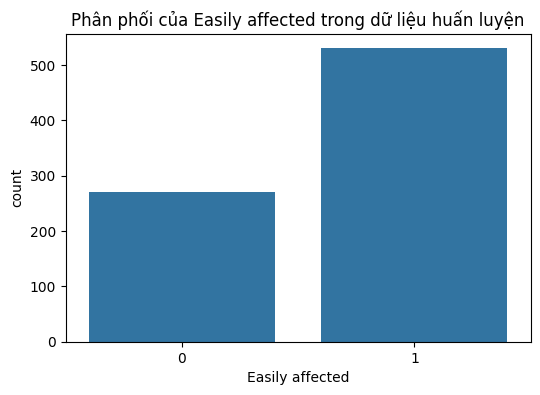

Tỷ lệ của biến 'Easily affected':
Easily affected
1    66.25
0    33.75
Name: proportion, dtype: float64


In [14]:
# Phân phối của biến mục tiêu
plt.figure(figsize=(6, 4))
sns.countplot(x='Easily affected', data=train_df)
plt.title("Phân phối của Easily affected trong dữ liệu huấn luyện")
plt.show()

# Tính toán tỷ lệ phần trăm
affected_counts = train_df['Easily affected'].value_counts(normalize=True) * 100
print("Tỷ lệ của biến 'Easily affected':")
print(affected_counts)

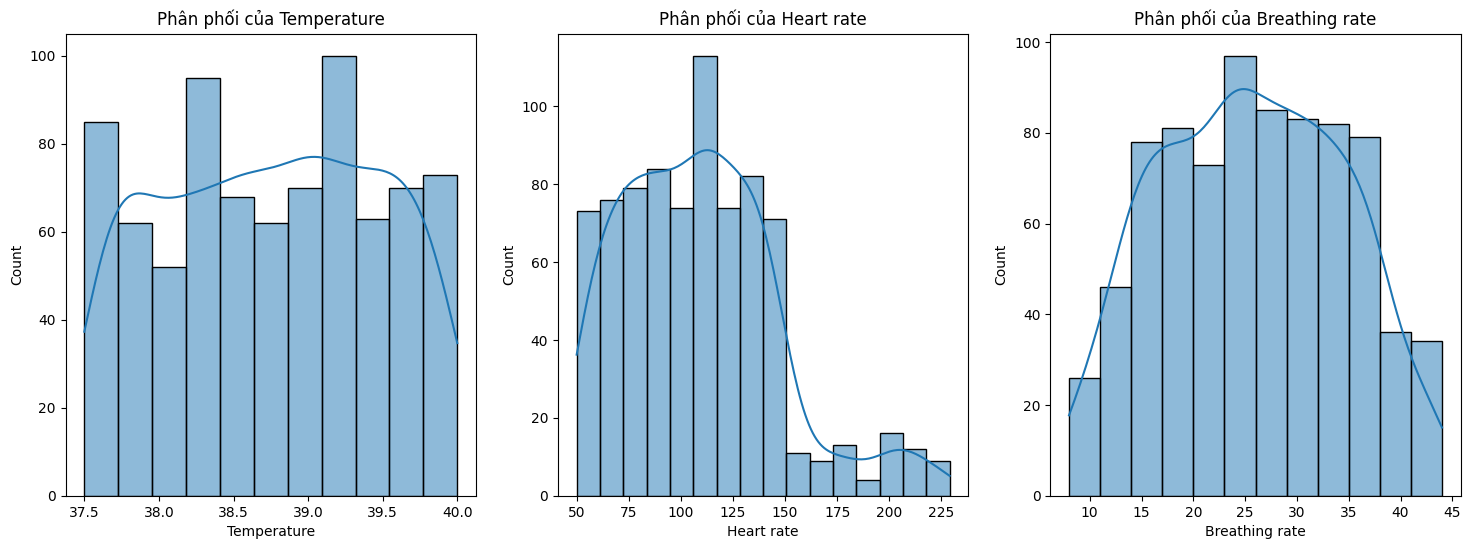

In [15]:
# Các phân phối của nhiệt độ, nhịp tim và nhịp thở
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(train_df['Temperature'], kde=True, ax=axs[0])
axs[0].set_title("Phân phối của Temperature")

sns.histplot(train_df['Heart rate'], kde=True, ax=axs[1])
axs[1].set_title("Phân phối của Heart rate")

sns.histplot(train_df['Breathing rate'], kde=True, ax=axs[2])
axs[2].set_title("Phân phối của Breathing rate")
plt.show()


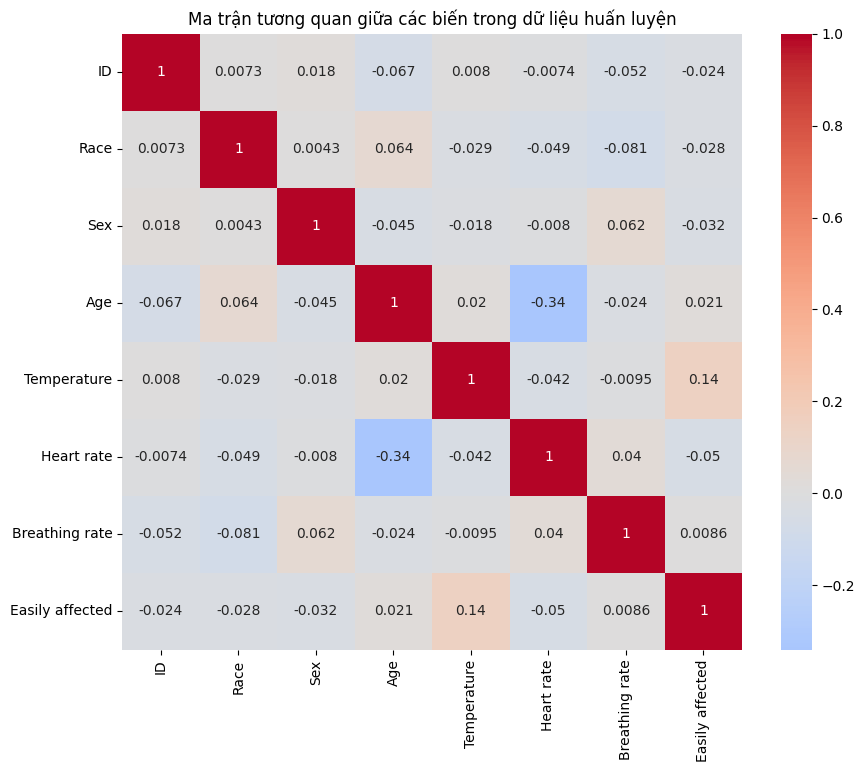

In [16]:
# Ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Ma trận tương quan giữa các biến trong dữ liệu huấn luyện")
plt.show()


In [32]:
# Tách dữ liệu đầu vào và mục tiêu
X_train = train_df.drop('Easily affected', axis=1)
y_train = train_df['Easily affected']
X_test = test_df.copy()

# Xóa cột 'ID' khỏi cả hai tập dữ liệu nếu không cần thiết cho mô hình
X_train = X_train.drop(columns=['ID'], errors='ignore')
X_test = X_test.drop(columns=['ID'], errors='ignore')

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Chia dữ liệu từ tập huấn luyện thành train_split và validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Khởi tạo và kiểm tra chéo trên tập train_split
model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(model, X_train_split, y_train_split, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Sử dụng GridSearchCV để tìm tham số tối ưu trên tập train_split
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15, None]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)

# Đánh giá mô hình tối ưu trên tập validation set
best_rf_model = grid_search.best_estimator_
val_predictions = best_rf_model.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, val_predictions)
val_roc_auc = roc_auc_score(y_val_split, val_predictions)

print("Đánh giá mô hình tối ưu trên tập kiểm tra (validation set):")
print(f"Accuracy: {val_accuracy}")
print("Classification Report:\n", classification_report(y_val_split, val_predictions))
print(f"ROC-AUC Score: {val_roc_auc}")

# Huấn luyện mô hình với toàn bộ tập train và dự đoán trên tập kiểm tra
best_rf_model.fit(X_train_scaled, y_train)
test_predictions = best_rf_model.predict(X_test_scaled)

# Xuất kết quả ra file submission.csv
# Tạo cột ID giả
submission = pd.DataFrame({'ID': range(1, len(test_predictions) + 1), 'Easily affected': test_predictions})
submission.to_csv('submission.csv', index=False)

Cross-validation scores: [0.9375    0.9140625 0.8984375 0.9296875 0.9296875]
Mean cross-validation score: 0.921875
Đánh giá mô hình tối ưu trên tập kiểm tra (validation set):
Accuracy: 0.96875
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        62
           1       0.96      0.99      0.97        98

    accuracy                           0.97       160
   macro avg       0.97      0.96      0.97       160
weighted avg       0.97      0.97      0.97       160

ROC-AUC Score: 0.9626398946675445


C:\Users\PC\AppData\Local\Temp\ipykernel_14532\3532315761.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


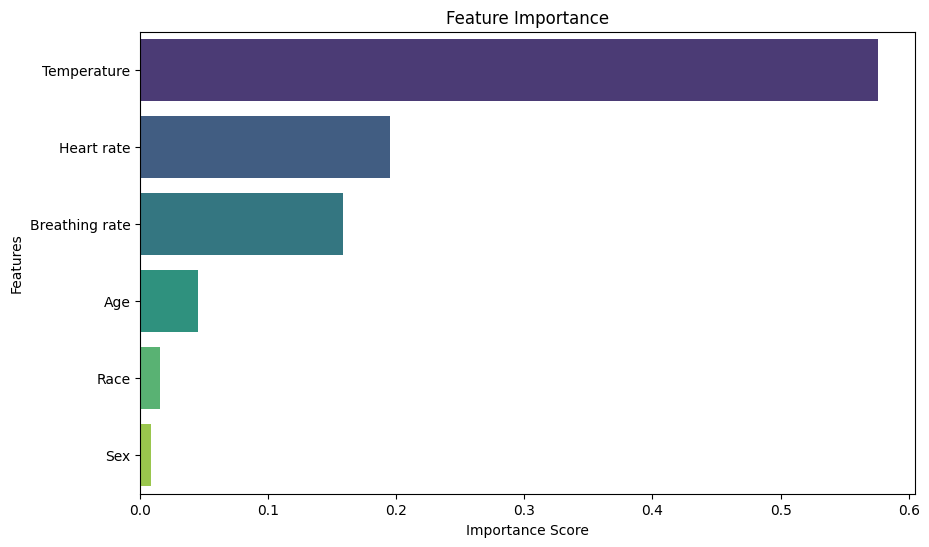

In [37]:
# Assuming rf_model is already trained and X_train is your feature set
# Calculate feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [38]:
import joblib

# Lưu mô hình
joblib.dump(best_rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo và huấn luyện một cây quyết định
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train_scaled, y_train)  # Sử dụng dữ liệu huấn luyện đã chuẩn bị


DecisionTreeClassifier(max_depth=3, random_state=42)

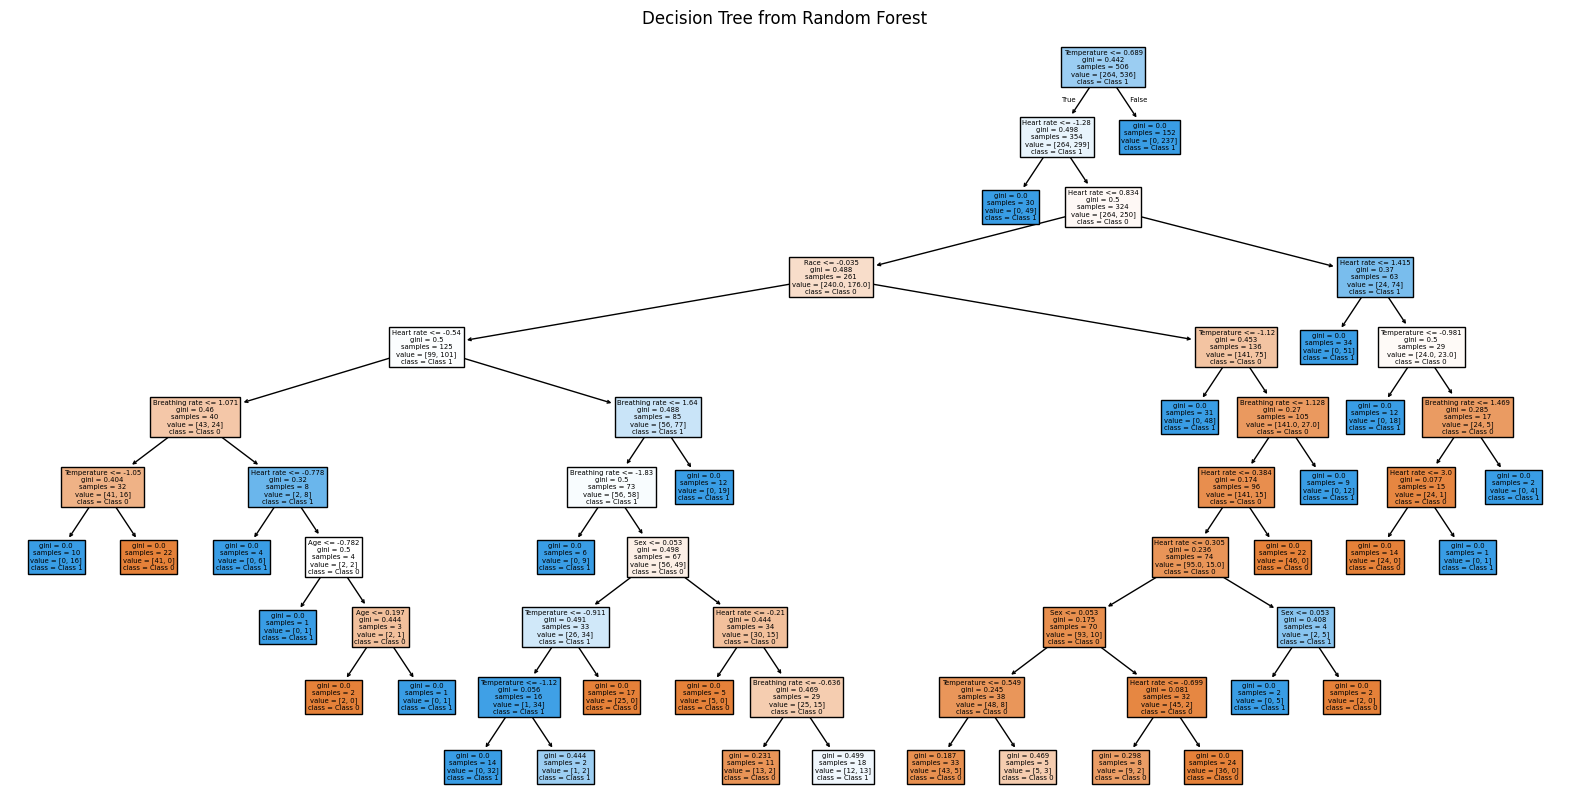

In [40]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Lấy một cây từ mô hình Random Forest
estimator = best_rf_model.estimators_[0]  # Chọn cây đầu tiên trong rừng

# Vẽ cây quyết định
plt.figure(figsize=(20,10))
plot_tree(estimator, filled=True, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree from Random Forest')
plt.show()

In [50]:
import joblib
import numpy as np

# Tải mô hình đã lưu bằng joblib
random_forest_model = joblib.load("random_forest_model.pkl")

# Chuẩn bị dữ liệu đầu vào
input_data = np.array([[2,0,13,38.6,91,22]])  # dữ liệu của chó

# Dự đoán trực tiếp
prediction = random_forest_model.predict(input_data)
print(prediction)
# Hiển thị kết quả
if prediction[0] == 1:
    print("Easily affected: 1 (bị bệnh)")
else:
    print("Easily affected: 0 (khỏe mạnh)")

[1]
Easily affected: 1 (bị bệnh)
